In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string 

In [2]:
data1 = pd.read_csv('C:/Users/Jagriti Shahi/Desktop/Docs/projects/fakenews/Untitled Folder/FakeNews-Detection-master/dataset/train_news.csv')
data2 = pd.read_csv('C:/Users/Jagriti Shahi/Desktop/Docs/projects/fakenews/Untitled Folder/FakeNews-Detection-master/dataset/train.csv')


In [3]:
data1.head()

,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [4]:
data2.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
data1=data1.iloc[:,1:]

In [6]:
data1.head()

,id,headline,written_by,news,label
0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [7]:
data1['text']=data1['headline']+data1['written_by']+data1['news']
del data1['headline']
del data1['written_by']
del data1['news']
data1.head()

,id,label,text
0,9653,0,Ethics Questions Dogged Agriculture Nominee as...
1,10041,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...
2,19113,0,Cotton to House: ’Do Not Walk the Plank and Vo...
3,6868,0,"Paul LePage, Besieged Maine Governor, Sends Co..."
4,7596,1,A Digital 9/11 If Trump WinsFinian Cunningham ...


In [8]:
del data1['id']
data1.head()

,label,text
0,0,Ethics Questions Dogged Agriculture Nominee as...
1,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...
2,0,Cotton to House: ’Do Not Walk the Plank and Vo...
3,0,"Paul LePage, Besieged Maine Governor, Sends Co..."
4,1,A Digital 9/11 If Trump WinsFinian Cunningham ...


In [9]:
data2['text']=data2['author']+data2['title']+data2['text']
del data2['author']
del data2['title']
del data2['id']

In [10]:
data2.head()

,text,label
0,Darrell LucusHouse Dem Aide: We Didn’t Even Se...,1
1,"Daniel J. FlynnFLYNN: Hillary Clinton, Big Wom...",0
2,Consortiumnews.comWhy the Truth Might Get You ...,1
3,Jessica Purkiss15 Civilians Killed In Single U...,1
4,Howard PortnoyIranian woman jailed for fiction...,1


In [11]:
data = pd.concat([data1, data2], ignore_index=True, sort=False)
data.head()

,label,text
0,0,Ethics Questions Dogged Agriculture Nominee as...
1,0,U.S. Must Dig Deep to Stop Argentina’s Lionel ...
2,0,Cotton to House: ’Do Not Walk the Plank and Vo...
3,0,"Paul LePage, Besieged Maine Governor, Sends Co..."
4,1,A Digital 9/11 If Trump WinsFinian Cunningham ...


In [12]:
data.isnull().sum()

label       0
text     5030
dtype: int64

In [13]:
data.dropna()
data.shape

(41600, 2)

In [14]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
from nltk.corpus import stopwords
import nltk
import warnings
warnings.filterwarnings("ignore")


def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)


def cleanup(text):
    text = textClean(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text


def constructLabeledSentences(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences


def getEmbeddings(data,vector_dimension=300):

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index'] ,axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = cleanup(data.loc[i,'text'])

    x = constructLabeledSentences(data['text'])
    y = data['label'].values

    text_model = Doc2Vec(min_count=1, window=5, vector_size=vector_dimension, sample=1e-4, negative=5, workers=7, epochs=10,
                         seed=1)
    text_model.build_vocab(x)
    text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.iter)

    train_size = int(0.8 * len(x))
    test_size = len(x) - train_size

    text_train_arrays = np.zeros((train_size, vector_dimension))
    text_test_arrays = np.zeros((test_size, vector_dimension))
    train_labels = np.zeros(train_size)
    test_labels = np.zeros(test_size)

    for i in range(train_size):
        text_train_arrays[i] = text_model.docvecs['Text_' + str(i)]
        train_labels[i] = y[i]

    j = 0
    for i in range(train_size, train_size + test_size):
        text_test_arrays[j] = text_model.docvecs['Text_' + str(i)]
        test_labels[j] = y[i]
        j = j + 1

    return text_train_arrays, text_test_arrays, train_labels, test_labels

In [15]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os
import scikitplot.plotters as skplt
def plot_cmat(yte1, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte1,ypred)
    plt.show()
if not os.path.isfile('./xtr.npy') or \
not os.path.isfile('./xte.npy') or \
not os.path.isfile('./ytr.npy') or \
not os.path.isfile('./yte.npy'):
    xtr1,xte1,ytr1,yte1 = getEmbeddings(data)
    np.save('./xtr', xtr1)
    np.save('./xte', xte1) 
    np.save('./ytr', ytr1)
    np.save('./yte', yte1)

xtr1 = np.load('./xtr.npy')
xte1= np.load('./xte.npy')
ytr1= np.load('./ytr.npy')
yte1= np.load('./yte.npy')



In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [17]:
model=KNeighborsClassifier()
model.fit(xtr1, ytr1)
ypred=model.predict(xte1)

In [18]:
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
performance=[]
accuracy1 = accuracy_score(yte1, ypred)
performance.append(accuracy1*100)
print('Accuracy: %.2f%%' % (accuracy1*100))

Accuracy: 87.57%


In [19]:
model=RandomForestClassifier()
model.fit(xtr1, ytr1)
ypred=model.predict(xte1)

In [20]:
accuracy2 = accuracy_score(yte1, ypred)
performance.append(accuracy2*100)
print('Accuracy: %.2f%%' % (accuracy2*100))

Accuracy: 93.04%


In [21]:
def clean_data(data):
    vector_dimension=300
        
    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index'],axis=1)

    for i in range(len(data)):
        data.loc[i, 'text'] = cleanup(data.loc[i,'text'])

    data = data.sample(frac=1).reset_index(drop=True)

    x = data.loc[:,'text'].values
    y = data.loc[:,'label'].values

    train_size = int(0.8 * len(y))
    test_size = len(x) - train_size

    xtr = x[:train_size]
    xte = x[train_size:]
    ytr = y[:train_size]
    yte = y[train_size:]

    np.save('xtr_shuffled.npy',xtr)
    np.save('xte_shuffled.npy',xte)
    np.save('ytr_shuffled.npy',ytr)
    np.save('yte_shuffled.npy',yte)

In [22]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt
top_words = 5000
epoch_num = 5
batch_size = 64

def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()

if not os.path.isfile('./xtr_shuffled.npy') or \
    not os.path.isfile('./xte_shuffled.npy') or \
    not os.path.isfile('./ytr_shuffled.npy') or \
    not os.path.isfile('./yte_shuffled.npy'):
    clean_data(data)


xtr = np.load('./xtr_shuffled.npy',allow_pickle=True)
xte = np.load('./xte_shuffled.npy',allow_pickle=True)
y_train = np.load('./ytr_shuffled.npy',allow_pickle=True)
y_test = np.load('./yte_shuffled.npy',allow_pickle=True)



In [23]:
cnt = Counter()
x_train = []
for x in xtr:
    x_train.append(x.split())
    for word in x_train[-1]:
        cnt[word] += 1  



In [24]:
# Storing most common words
most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1

# Encode the sentences
for news in x_train:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

y_train = list(y_train)
y_test = list(y_test)

# Delete the short news
i = 0
while i < len(x_train):
    if len(x_train[i]) > 10:
        i += 1
    else:
        del x_train[i]
        del y_train[i]

# Generating test data
x_test = []
for x in xte:
    x_test.append(x.split())

# Encode the sentences
for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160064    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 213,365
Trainable params: 213,365
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
453/453 [==============================] - 624s 1s/step - loss: 0.2377 - accuracy: 0.9065 - val_loss: 0.1571 - val_accuracy: 0.9494
Epoch 2/5
453/453 [==============================] - 745s 2s/step - loss: 0.0969 - accuracy: 0.9696 - val_loss: 0.0949 - val_accuracy: 0.9692
Epoch 3/5
453/453 [==============================] - 768s 2s/step - loss: 0.0983 - accuracy

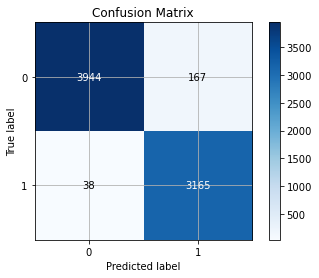

In [25]:

# Truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Create the model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))
performance.append(scores[1]*100)
# Draw the confusion matrix
y_pred = model.predict_classes(X_test)
plot_cmat(y_test, y_pred)

Text(0.5, 1.0, 'Comparison of algorithms')

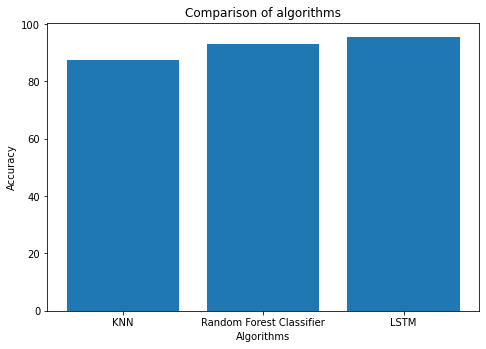

In [26]:
algo=['KNN','Random Forest Classifier','LSTM']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(algo,performance)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
plt.title("Comparison of algorithms")